# Exploring the differences between medicinal and non medicinal plants using chemical classes

### Import modules

In [1]:
from collections import defaultdict
from ast import literal_eval
import os

import pandas as pd
import numpy as np
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants, create_np_classifier_vectors, collapse_vector_to_family

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# PCA
from sklearn.decomposition import PCA

# T-SNE
from openTSNE import TSNE

In [2]:
mpl.rcParams['figure.dpi'] = 400
sns.set(context='poster', style='dark')
tqdm.pandas()

Load plant-chemical and plant-disease associations

In [3]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
)

In [4]:
plant_disease_df.head(1)

,plant_curie,plant_name,disease_curie,database,evidence
0,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10067319_8


Medicinal plants

In [5]:
medicinal_plants = plant_disease_df.plant_curie.unique()

Load chemicals

In [6]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [7]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [8]:
len(plant_chemical_df.chemical_curie.unique())

87026

### Annontate medicinal and non-medicinal plants

In [9]:
plant_chemical_df['plant_type'] = plant_chemical_df['plant_curie'].progress_map(
    lambda x: 'Medicinal' if x in medicinal_plants else 'Non-medicinal'
)

100%|██████████| 383606/383606 [01:55<00:00, 3330.81it/s]


In [10]:
plant_chemical_df.head(2)

,plant_curie,chemical_curie,plant_type
0,ncbitaxon:1000425,pubchem.compound:3527,Non-medicinal
1,ncbitaxon:1000425,pubchem.compound:68082,Non-medicinal


### Extract chemical classes

Load NPClassifier classes

In [11]:
np_classifier_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/npclassifier_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_openeye_can_smiles',
        'class_results'
    ],
    index_col='pubchem_openeye_can_smiles'
).to_dict()['class_results']

In [12]:
len(np_classifier_dict)

638605

Convert the SMILEs to PubChem ids

In [13]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [14]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 89270/89270 [00:00<00:00, 393811.69it/s]


In [15]:
# Multiple classes associated with each chemical
np_classifier_dict = {
    smiles_to_pubchem[smile]: literal_eval(classes)
    for smile, classes in np_classifier_dict.items()
    if smile in smiles_to_pubchem and len(literal_eval(classes)) > 0
}
len(np_classifier_dict)

52434

### Compound class annotation

In [16]:
if os.path.exists('../data/np_classifier_annotated_plants.pq'):
    np_classifier_annotated_plants = pd.read_parquet('../data/np_classifier_annotated_plants.pq')
else:
    np_classifier_annotated_plants = plant_chemical_df.copy(deep=True)
    np_classifier_annotated_plants['class'] = np_classifier_annotated_plants['chemical_curie'].map(np_classifier_dict)
    np_classifier_annotated_plants = np_classifier_annotated_plants.explode('class')

    # Drop plants with no annotation
    np_classifier_annotated_plants.dropna(subset=['class'], inplace=True)

    np_classifier_annotated_plants.to_parquet('../data/np_classifier_annotated_plants.pq')

In [17]:
np_classifier_annotated_plants.head(2)

,plant_curie,chemical_curie,plant_type,class
index,,,,
0,ncbitaxon:1000425,pubchem.compound:3527,Non-medicinal,Polyprenylated cyclic polyketides (Hop meroter...
1,ncbitaxon:1000425,pubchem.compound:68082,Non-medicinal,Furocoumarins


### Create plant-class vectors
e.g., plant A: [class1, class2, class3, ...]

In [18]:
if os.path.exists('../data/np_classifier_genus_vector.pq'):
    plant_to_npclassifier_vectors = pd.read_parquet('../data/np_classifier_genus_vector.pq')
else:
    # Time consuming step
    plant_to_npclassifier_vectors = create_np_classifier_vectors(np_classifier_annotated_plants)
    plant_to_npclassifier_vectors.to_parquet('../data/np_classifier_genus_vector.pq')

In [19]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Mycosporine and Mycosporine-like amino acids,Verrucosane diterpenoids,Carbazole alkaloids,Iboga type,Abietane diterpenoids,Nardosinane sesquiterpenoids,Farnesane sesquiterpenoids,Cephamycins,Kaurane and Phyllocladane diterpenoids,...,Resin glycosides,Cinnamoyl phenols,Lactarane sesquiterpenoids,Stictane triterpenoids,Pyrroloindole alkaloids,Kavalactones and derivatives,12-oxophytodienoic acid metabolites,Thujane monoterpenoids,Presilphiperfolane and Probotryane sesquiterpenoids,Other Eicosanoids
0,ncbitaxon:1209861,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ncbitaxon:493991,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Mycosporine and Mycosporine-like amino acids,Verrucosane diterpenoids,Carbazole alkaloids,Iboga type,Abietane diterpenoids,Nardosinane sesquiterpenoids,Farnesane sesquiterpenoids,Cephamycins,Kaurane and Phyllocladane diterpenoids,...,Resin glycosides,Cinnamoyl phenols,Lactarane sesquiterpenoids,Stictane triterpenoids,Pyrroloindole alkaloids,Kavalactones and derivatives,12-oxophytodienoic acid metabolites,Thujane monoterpenoids,Presilphiperfolane and Probotryane sesquiterpenoids,Other Eicosanoids
0,ncbitaxon:1209861,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ncbitaxon:493991,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Collapsing plant species to plant families

In [21]:
# Time consuming step
_, family_to_species = get_genus_and_family_info_for_plants(
        set(plant_chemical_df.plant_curie.unique())
    )

order genus: 100%|██████████| 16884/16884 [00:01<00:00, 15830.79it/s]


In [25]:
plant_chemical_df.head(2)

,plant_curie,chemical_curie,plant_type
0,ncbitaxon:1000425,pubchem.compound:3527,Non-medicinal
1,ncbitaxon:1000425,pubchem.compound:68082,Non-medicinal


In [27]:
if os.path.exists('../data/np_classifier_family_vector.parquet'):
    np_classifier_family_df = pd.read_parquet('../data/np_classifier_family_vector.parquet')
else:
    np_classifier_family_df = collapse_vector_to_family(
        plant_chemical_df, plant_to_npclassifier_vectors, family_to_species
    )
    np_classifier_family_df.fillna(0, inplace=True)
    np_classifier_family_df.to_parquet('../data/np_classifier_family_vector.parquet', index=False)

100%|██████████| 513/513 [00:06<00:00, 80.57it/s] 


Empty skipped - 24
Medicinal skipped - 247
Non-medicinal skipped - 34


In [28]:
np_classifier_family_df.head(2)

,Mycosporine and Mycosporine-like amino acids,Verrucosane diterpenoids,Carbazole alkaloids,Iboga type,Abietane diterpenoids,Nardosinane sesquiterpenoids,Farnesane sesquiterpenoids,Cephamycins,Kaurane and Phyllocladane diterpenoids,Capsaicins and Capsaicinoids,...,Lactarane sesquiterpenoids,Stictane triterpenoids,Pyrroloindole alkaloids,Kavalactones and derivatives,12-oxophytodienoic acid metabolites,Thujane monoterpenoids,Presilphiperfolane and Probotryane sesquiterpenoids,Other Eicosanoids,family,ftype
0,0,0,3,0,181,1,28,0,122,0,...,0,0,0,5,0,58,0,1,ncbitaxon:4136,Medicinal
1,0,0,26,0,307,0,31,0,615,0,...,0,0,0,4,0,77,0,0,ncbitaxon:4136,Non-medicinal


### Converting to percentage

In [29]:
def convert_to_percent(df: pd.DataFrame):
    """Convert counts to percentages for each row."""
    df.set_index(['family', 'ftype'], inplace=True)
    res = df.div(df.sum(axis=1), axis=0)
    
    a = res.sum(axis=1) 
    assert np.isclose(a.values, [1]*a.shape[0]).all(), 'Not all rows sum to 1'
    return res

In [30]:
np_classifier_family_df = convert_to_percent(np_classifier_family_df)
np_classifier_family_df.head(2)

Mycosporine and Mycosporine-like amino acids  \
family         ftype                                                         
ncbitaxon:4136 Medicinal                                               0.0   
               Non-medicinal                                           0.0   

                              Verrucosane diterpenoids  Carbazole alkaloids  \
family         ftype                                                          
ncbitaxon:4136 Medicinal                           0.0             0.000380   
               Non-medicinal                       0.0             0.002891   

                              Iboga type  Abietane diterpenoids  \
family         ftype                                              
ncbitaxon:4136 Medicinal             0.0               0.022955   
               Non-medicinal         0.0               0.034138   

                              Nardosinane sesquiterpenoids  \
family         ftype                                         
ncbitaxon:4136 Medicinal                          0.000127   
               Non-medicinal                      0.000000   

                              Farnesane sesquiterpenoids  Cephamycins  \
family         ftype                                                    
ncbitaxon:4136 Medicinal                        0.003551          0.0   
               Non-medicinal                    0.003447          0.0   

                              Kaurane and Phyllocladane diterpenoids  \
family         ftype                                                   
ncbitaxon:4136 Medicinal                                    0.015472   
               Non-medicinal                                0.068387   

                              Capsaicins and Capsaicinoids  ...  \
family         ftype                                        ...   
ncbitaxon:4136 Medicinal                               0.0  ...   
               Non-medicinal                           0.0  ...   

                              Resin glycosides  Cinnamoyl phenols  \
family         ftype                                                
ncbitaxon:4136 Medicinal                   0.0           0.000254   
               Non-medicinal               0.0           0.000000   

                              Lactarane sesquiterpenoids  \
family         ftype                                       
ncbitaxon:4136 Medicinal                             0.0   
               Non-medicinal                         0.0   

                              Stictane triterpenoids  Pyrroloindole alkaloids  \
family         ftype                                                            
ncbitaxon:4136 Medicinal                         0.0                      0.0   
               Non-medicinal                     0.0                      0.0   

                              Kavalactones and derivatives  \
family         ftype                                         
ncbitaxon:4136 Medicinal                          0.000634   
               Non-medicinal                      0.000445   

                              12-oxophytodienoic acid metabolites  \
family         ftype                                                
ncbitaxon:4136 Medicinal                                      0.0   
               Non-medicinal                                  0.0   

                              Thujane monoterpenoids  \
family         ftype                                   
ncbitaxon:4136 Medicinal                    0.007356   
               Non-medicinal                0.008562   

                              Presilphiperfolane and Probotryane sesquiterpenoids  \
family         ftype                                                                
ncbitaxon:4136 Medicinal                                                    0.0     
               Non-medicinal                                                0.0     

                              Other Eicosanoids  
family         ftype                          

In [31]:
if not os.path.exists('../data/npclassifier_family_norm_vector.parquet'):
    np_classifier_family_df.to_csv('../data/npclassifier_family_norm_vector.parquet', index=True)

# TSNE

In [33]:
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = mpl.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            mpl.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

In [34]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [35]:
np_classifier_embedding_train = tsne.fit(np_classifier_family_df)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.18 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.15 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.6121, 50 iterations in 0.2867 sec
Iteration  100, KL divergence 2.5043, 50 iterations in 0.3516 sec
Iteration  150, KL divergence 2.4785, 50 iterations in 0.1892 sec
Iteration  200, KL divergence 2.4431, 50 iterations in 0.1991 sec
Iteration  250, KL divergence 2.5229, 50 iterations in 0.1701 sec
   --> Time elapsed: 1.20 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...

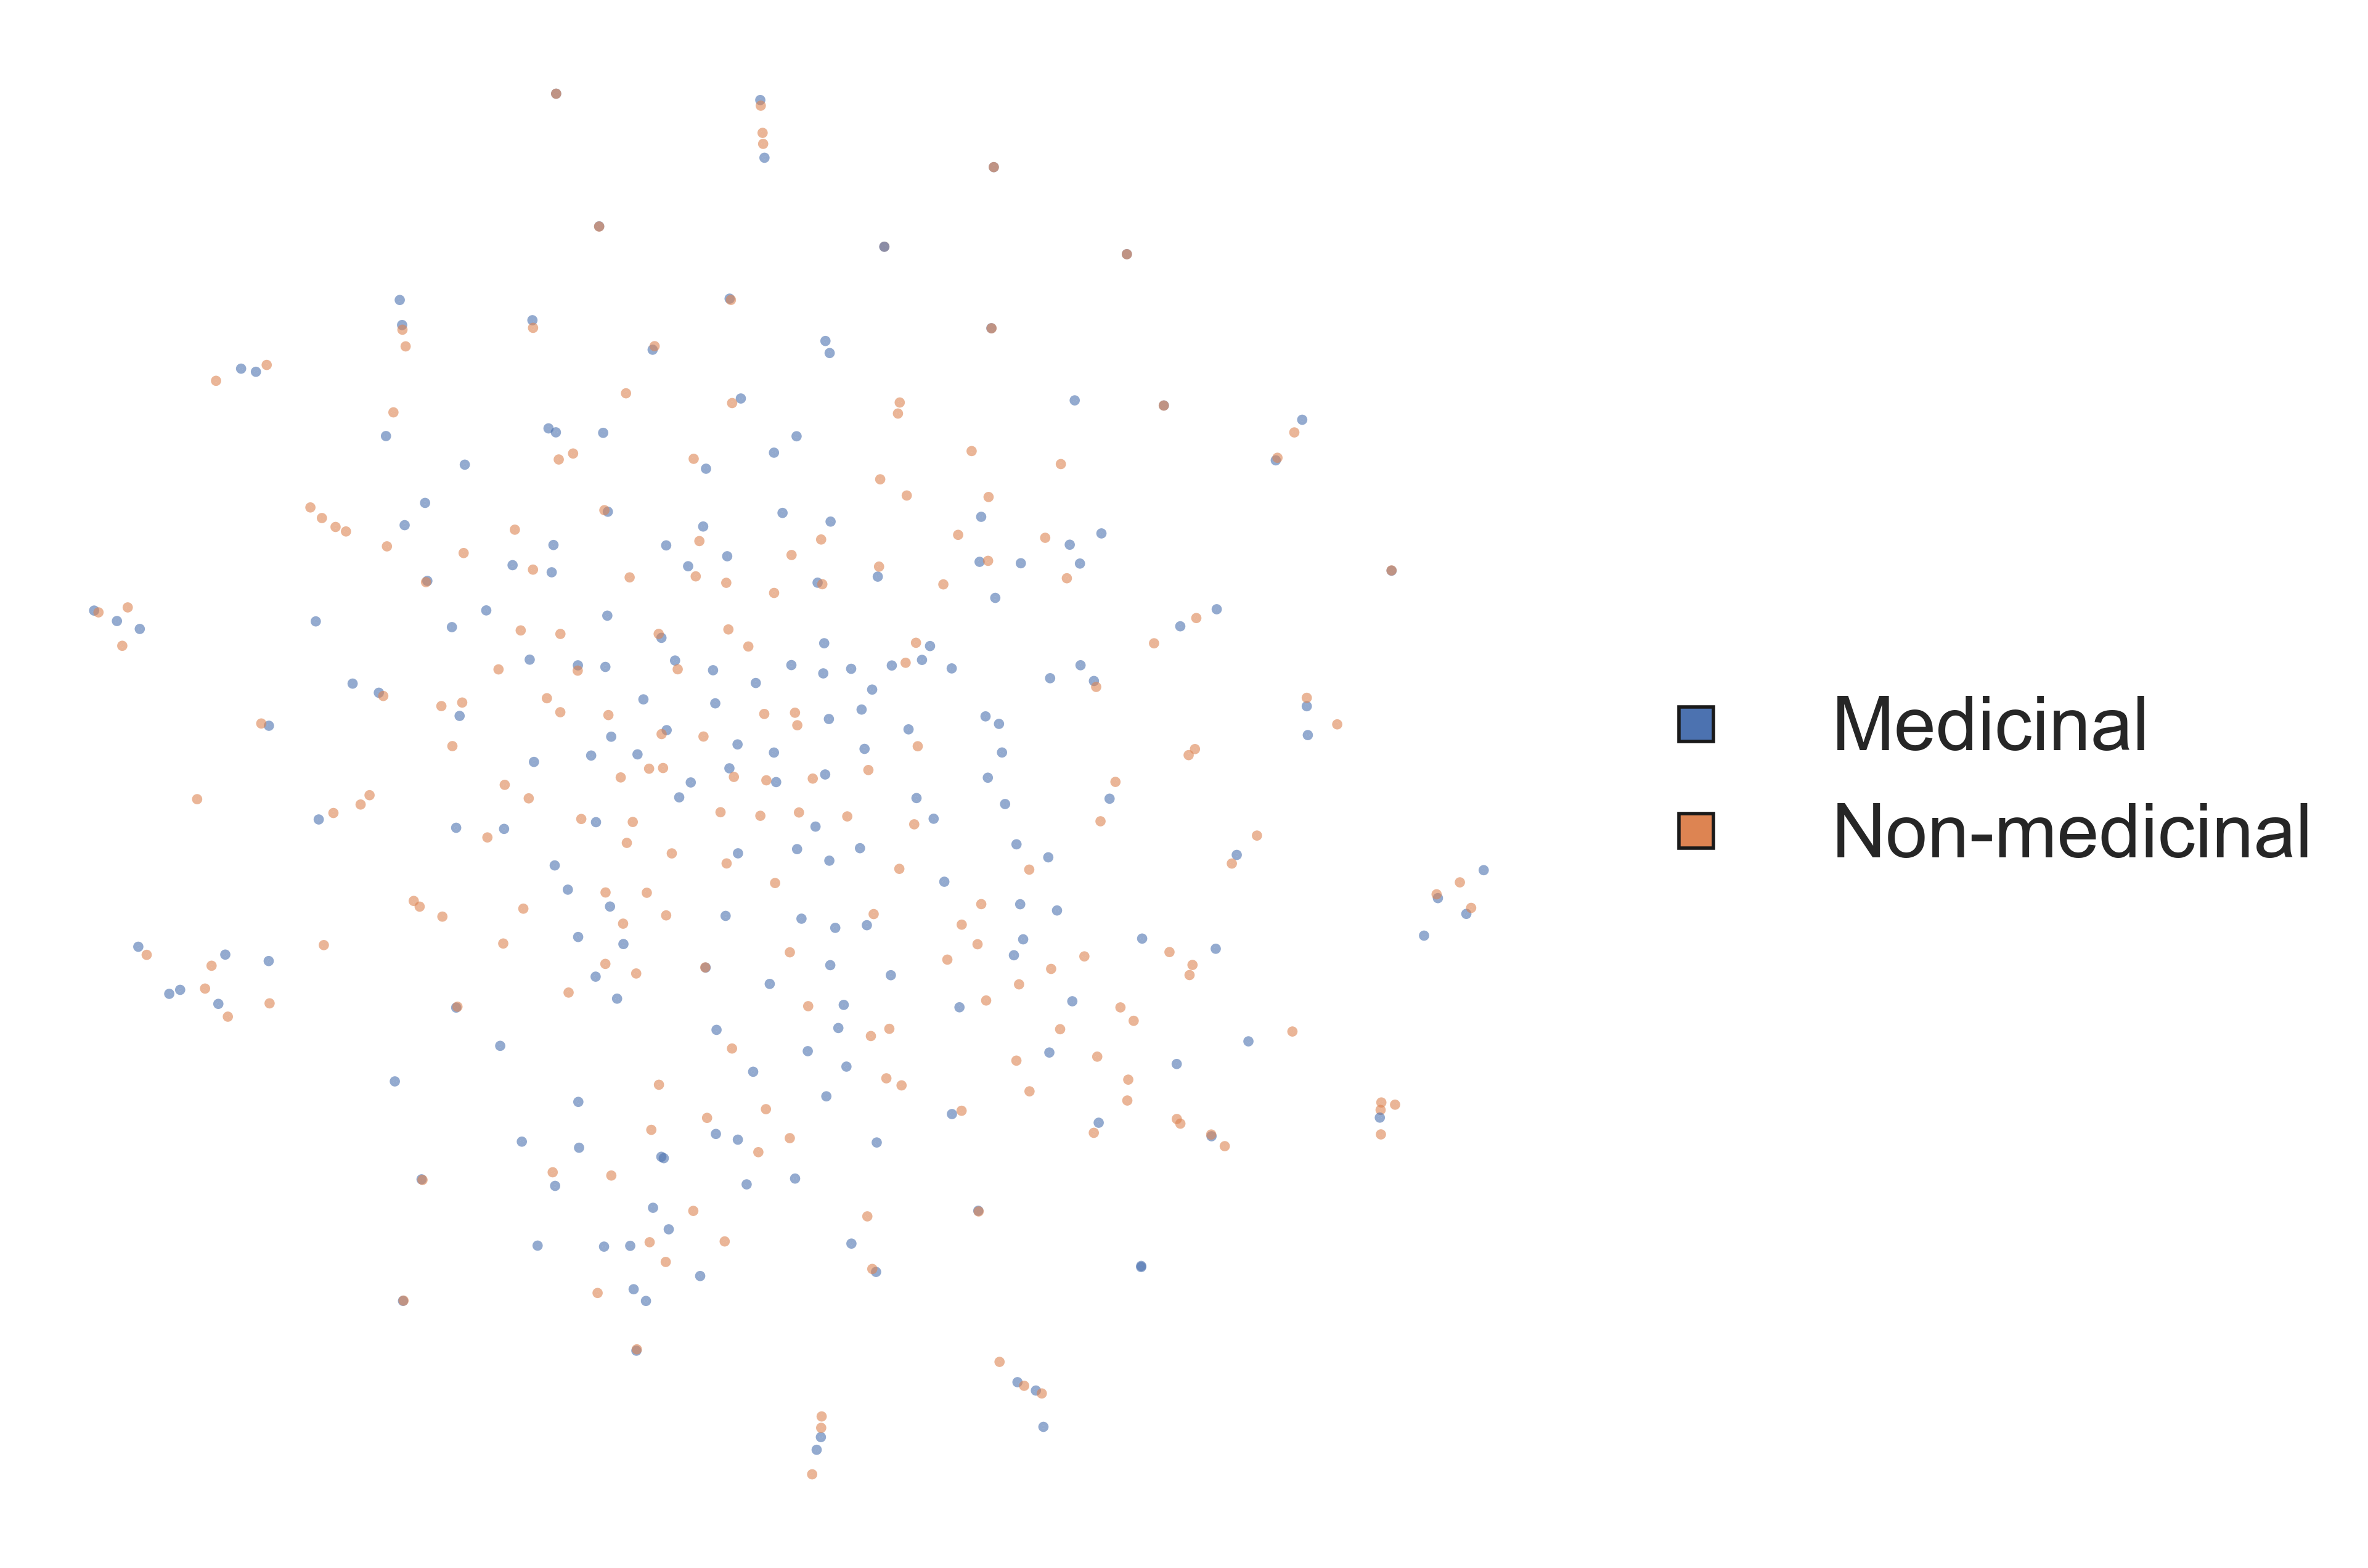

In [36]:
plot(np_classifier_embedding_train, np_classifier_family_df.index.get_level_values('ftype'))

### PCA plot

In [37]:
pca = PCA(n_components=2)

In [38]:
pca_npclassifire = PCA(n_components=2)
npclassifier_components = pca_npclassifire.fit_transform(np_classifier_family_df)

principal_npclassifier_df = pd.DataFrame(
    data = npclassifier_components, 
    columns = ['PC1', 'PC2']
)
principal_npclassifier_df['Type'] = np_classifier_family_df.index.get_level_values('ftype')

In [39]:
pca_npclassifire.explained_variance_ratio_

array([0.12102167, 0.06346418])

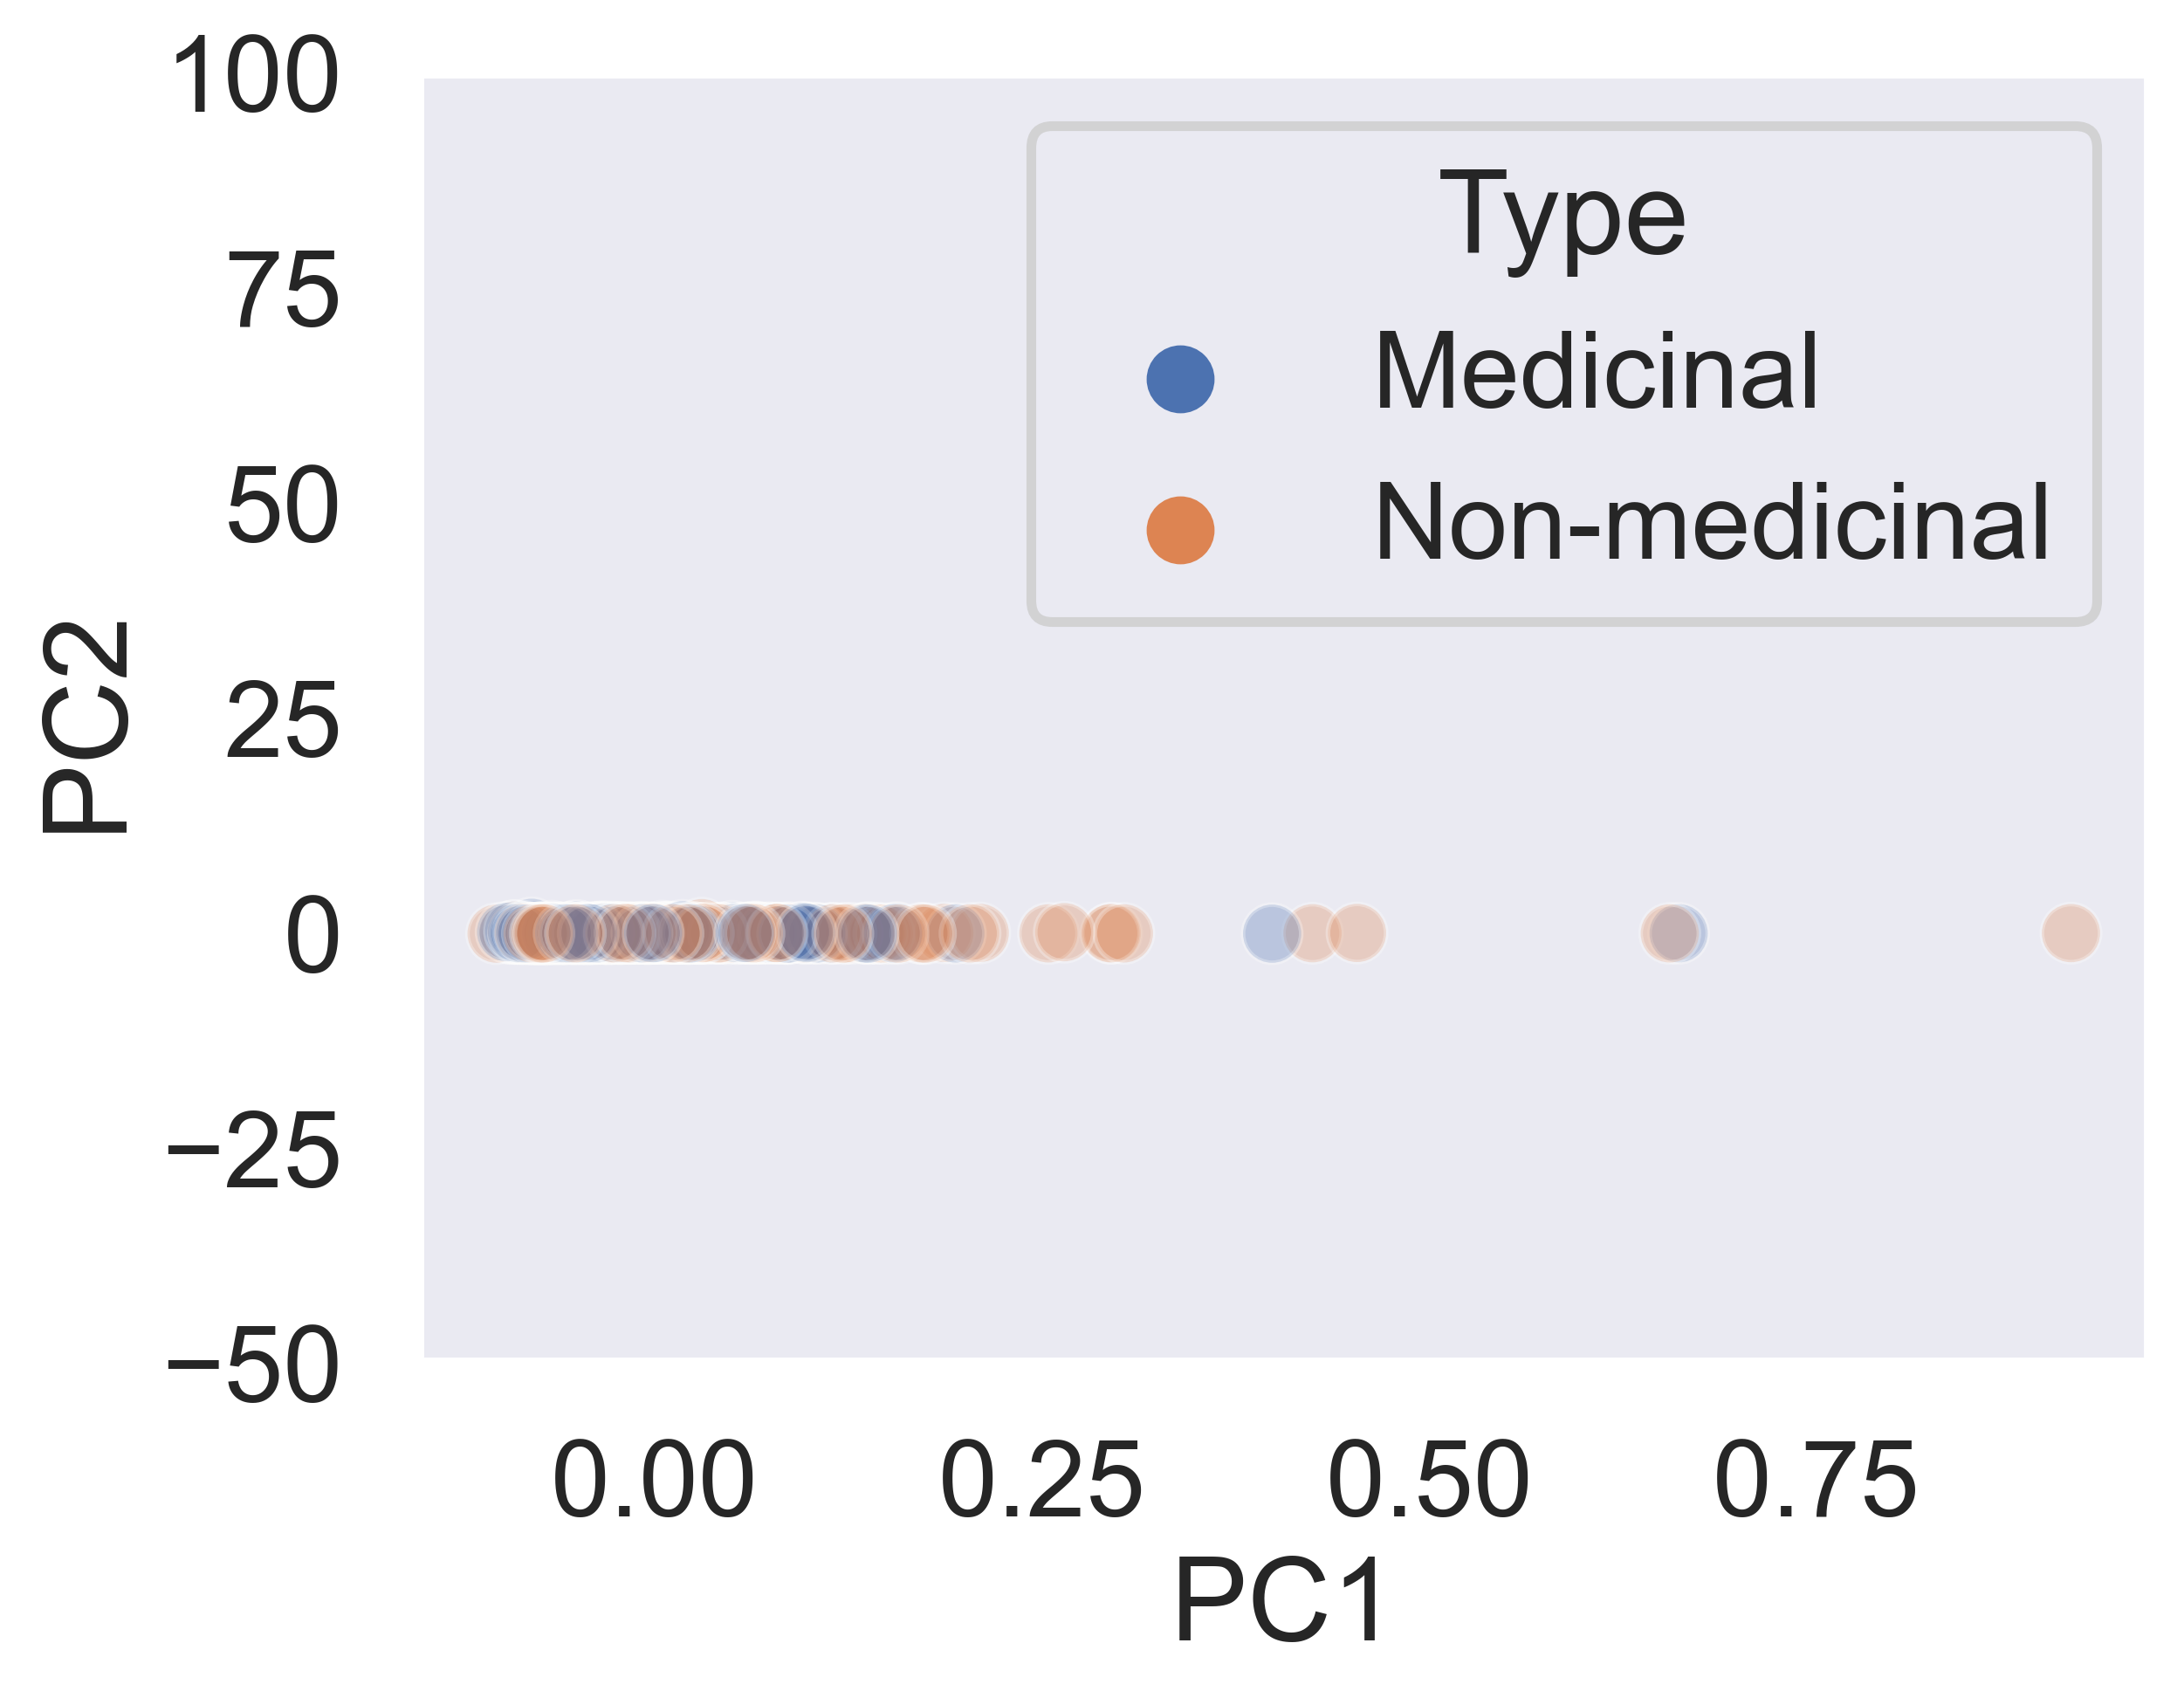

In [40]:
sns.scatterplot(
    data=principal_npclassifier_df,
    x='PC1',
    y='PC2',
    hue='Type',
    alpha=0.3
)
plt.ylim(-50, 100)
plt.show()